In [1]:
from dougnet.data import LoadMNIST
from dougnet.nograph import MultiLayerPerceptron
from dougnet.metrics import accuracy, r2
from dougnet.functions import (relu, 
                               tanh, 
                               softmax, 
                               softmax_cross_entropy_loss, 
                               l2regloss, 
                               sigmoid, 
                               identity,
                               l2loss)
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default') 

In This notebook I train several multi-layer perceptrons for classification and regression.  Vanilla MLPs are so simple that they can be trained with a closed form algorithm without resorting to a computational graph for automatic differentiation.  I use this algorithm (the dougnet `MultiLayerPerceptron` class in the `nograph` module) to train MLPs with the following data:
- MNIST
- synthetic spiral data
- synthetic sinusoidal data.

# MNIST Classification

Note that I train this model with float64 precision to be able to compare the results to the same computation performed on a computational graph in example notebook 2 (without have to worry about inconsistencies due simply to numerical precision).

### Load/prep data 

In [2]:
# define a few utility funcs

def PrepareData(X, y, n_classes, dtype=np.float32, seed=42, standardize=True):
    # one hot encode Ys
    Y_ohe = np.zeros((y.size, n_classes))
    Y_ohe[np.arange(y.size), y] = 1
    
    # standardize
    if standardize:
        X = ((X / 255.) - .5) * 2

    #transpose data 
    X = X.T
    Y_ohe = Y_ohe.T

    ## randomly shuffle columns (examples)
    random_perm_of_cols = np.random.RandomState(seed=seed).permutation(X.shape[1])
    X = X[:, random_perm_of_cols]
    Y_ohe = Y_ohe[:, random_perm_of_cols]
    
    return X.astype(dtype), Y_ohe.astype(dtype)


def displayData(X, examples, labels=None, cmap='gray_r', figsize=(20,10)):
    # set up array
    fig, ax = plt.subplots(nrows=examples.shape[0], ncols=examples.shape[1], 
                           figsize=figsize)
    # loop over randomly drawn numbers
    for i in range(examples.shape[0]):
        for j in range(examples.shape[1]):
            ind = examples[i, j]
            
            tmp = X[:, ind].reshape(28,28)
            if labels:
                ax[i,j].set_title("Label: {}".format(labels[ind]))
            ax[i,j].imshow(tmp, cmap=cmap) # display it as gray colors.
            plt.setp(ax[i,j].get_xticklabels(), visible=False)
            plt.setp(ax[i,j].get_yticklabels(), visible=False)
    
    fig.subplots_adjust(hspace=0.5, wspace=0.5)

In [3]:
# load data and basic data prep

X_train, Y_train, X_val, Y_val = LoadMNIST()
X_train, Y_train = PrepareData(X_train, Y_train, 10, dtype=np.float64)
X_val, Y_val = PrepareData(X_val, Y_val, 10, dtype=np.float64)

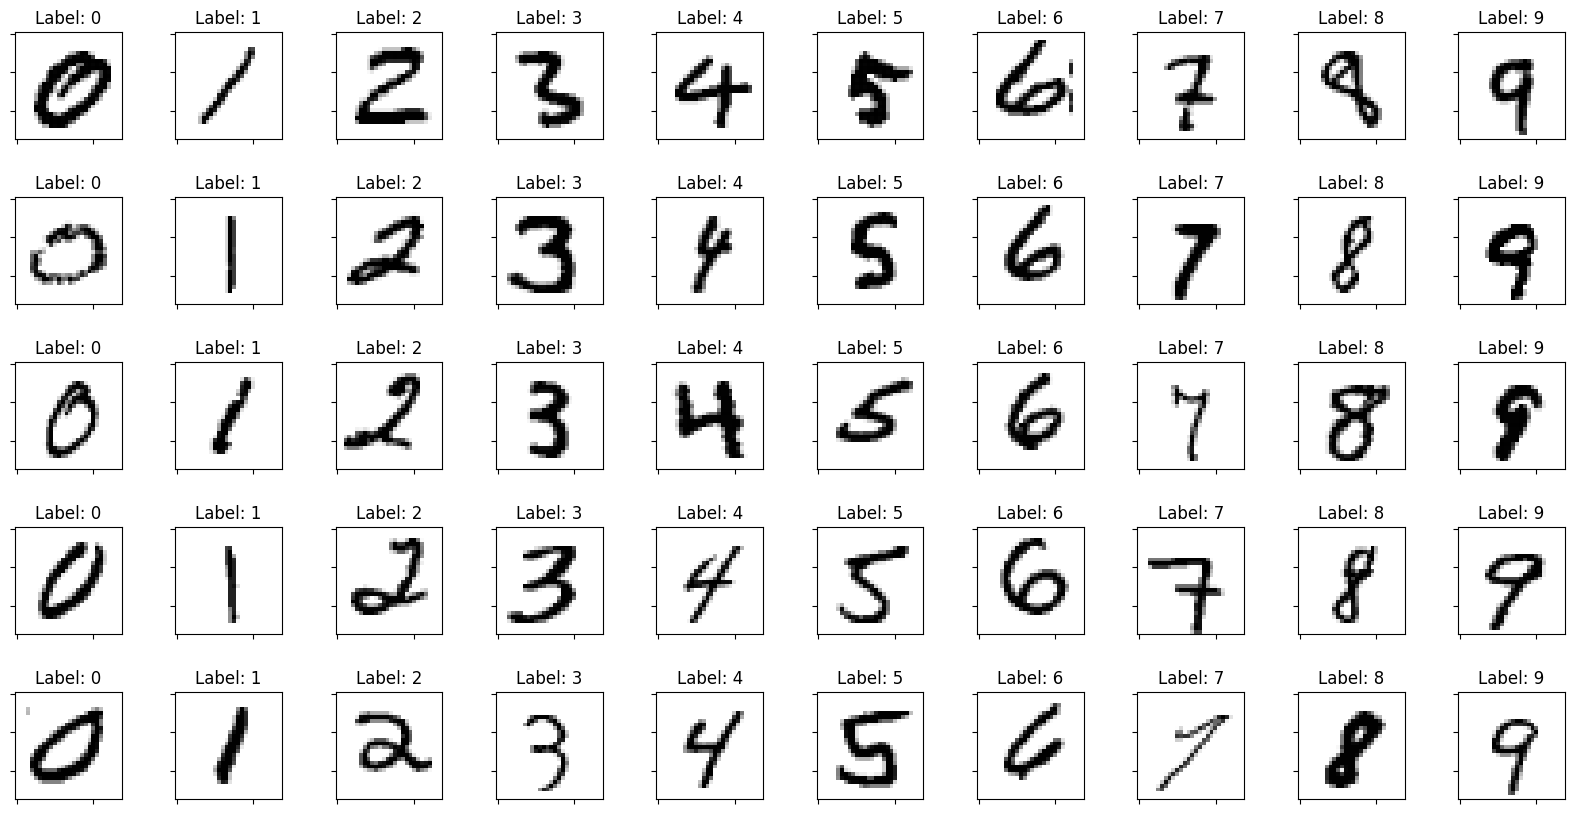

In [4]:
# display random examples of different digits

rand_examples = np.array([np.random.choice(np.where(Y_train[j, :] == 1)[0], 
                                           size=5, replace=False) 
                                           for j in range(10)]).T
displayData(X_train, rand_examples, labels=list(np.argmax((Y_train), axis=0)))

### Training

In [5]:
# instantiate and train model with 2 hidden layers and regularization

mlp = MultiLayerPerceptron([40, 40, 10], 
                           [tanh, relu, softmax], 
                           reg_loss=l2regloss, 
                           lmbda=0.01, 
                           eta=.01, 
                           batch_size=100, 
                           n_epochs=100, 
                           weight_seed=1984,
                           data_seed=2, 
                           progress_metric=accuracy, 
                           loss=softmax_cross_entropy_loss,
                           verbose=True)

mlp.fit(X_train, Y_train, X_val, Y_val);

epoch: 100%|███████████████| 100/100 [01:49<00:00,  1.09s/epoch, loss=0.2/0.2, score=0.95/0.95]                                                   


I plot the training and validation learning curves for the loss as well as acuracy.  We see that the curves for training and validation are very similar, indicating possible under-fitting.

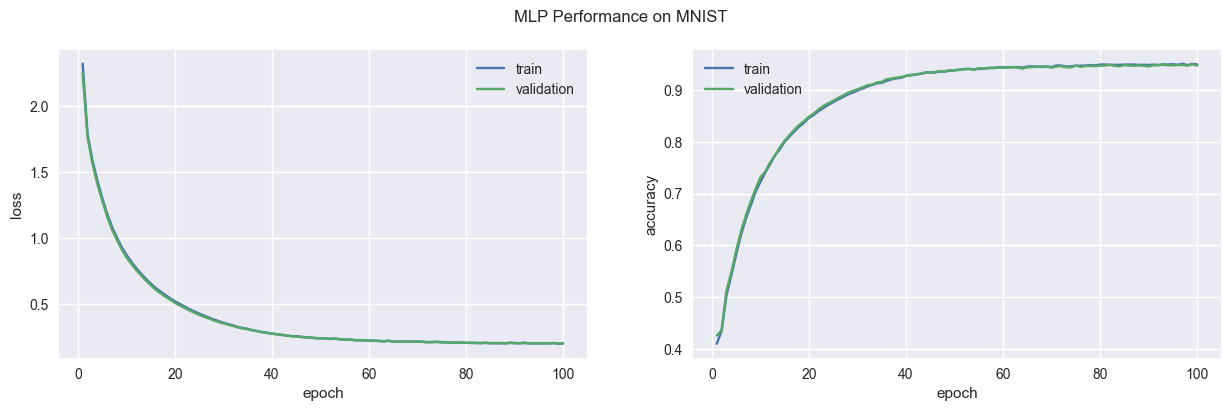

In [6]:
# plot training/validation progress
plt.style.use('seaborn-v0_8')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
fig.suptitle('MLP Performance on MNIST')

ax1.plot(range(1, len(mlp.score_train_) + 1), mlp.loss_train_, label='train')
ax1.plot(range(1, len(mlp.score_train_) + 1), mlp.loss_val_, label='validation')
ax1.set_xlabel("epoch")
ax1.set_ylabel("loss")
ax1.legend(loc="upper right");

ax2.plot(range(1, len(mlp.score_train_) + 1), mlp.score_train_, label='train')
ax2.plot(range(1, len(mlp.score_train_) + 1), mlp.score_val_, label='validation')
ax2.set_xlabel("epoch")
ax2.set_ylabel("accuracy")
ax2.legend(loc="upper left");

As a sanity check to diagnose potential bugs, we can check whether the initial loss is of the right order of magnitude.  For a neural network that outputs a probability distribution, $\hat{P}$, the cross-entropy loss associated with a datapoint, $(x, y)$, is given by $-\ln \hat{P} \left(y|x \right)$.  Therefore, the expected loss during the beginning of training is given by:
\begin{align}
\mathbb{E}_{X, Y, \mathcal{W}} \left [\ell(Y, \hat{Y}) \right] &= - \mathbb{E}_{X, Y, \mathcal{W}} \left [\ln \hat{P} \left(Y|X; \mathcal{W} \right) \right] \\
& = \ln \left (K \right),
\end{align}
where $\mathcal{W}$ represents the set of initial weights in the neural network.  In going from the first to second line I have utilized the fact that since the weights are initialized randomly, the network should not favor predicting any one class over the other so that $\hat{P}$ is initially a uniform distribution with probability $\frac{1}{K}$ for each class.

A reasonable statistical estimator for the expected loss is the sample mean loss, $\mathbb{E}_{X, Y, \mathcal{W}} \left [\ell(Y, \hat{Y}) \right] \approx \frac{1}{N} \sum_{x, y \in \mathcal{D}} \ell(y, \hat{y})$, which we typically track during training anyway to visualize learning curves.  Note that the sample mean loss only averages over a single realization over $\mathcal{W}$ (unless our model ensembles the predictions from several independent networks trained with different weight initializations).

In [7]:
print(f'Expected initial loss = {round(np.log(10), 2)}')
print(f'Mean training loss after first epoch = {round(mlp.loss_train_[0], 2)}')

Expected initial loss = 2.3
Mean training loss after first epoch = 2.32


Let's display some random examples of incorrect predictions.  We see that some of the errors are very reasonable as some of the handwritten digits are very atypical for their class.

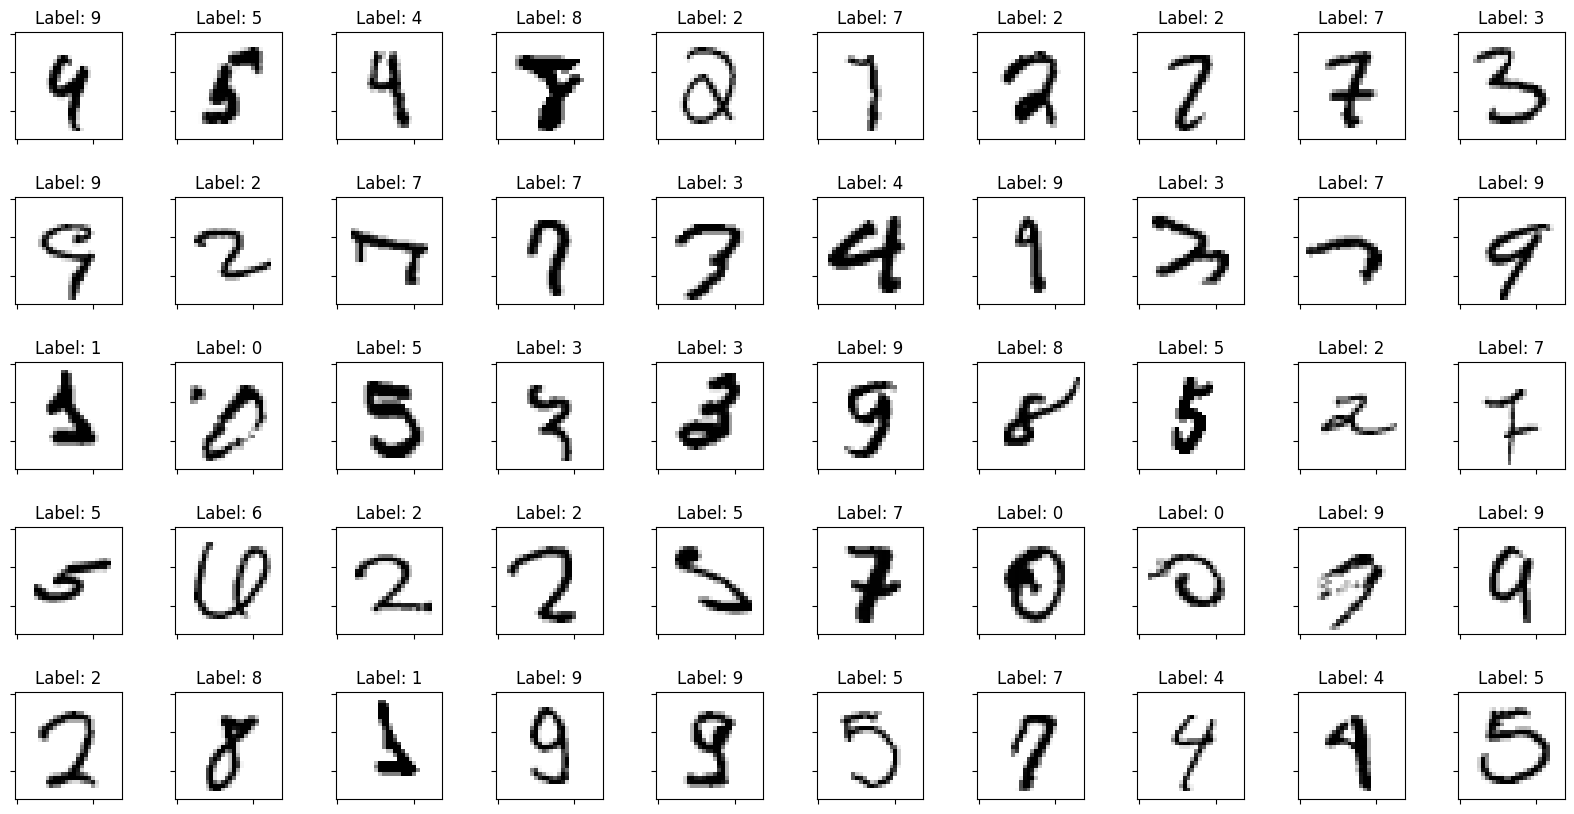

In [8]:
plt.style.use('default') 

ypreds = np.argmax(mlp.predict(X_val), axis=0)
yact = np.argmax(Y_val, axis=0)
incorrect_class = np.random.choice(np.where(yact != ypreds)[0], size=50, 
                                   replace=False).reshape(5, 10)

displayData(X_val, incorrect_class, labels=list(yact))

Finally, let's display the MLP weights in the first layer.  Since each neuron in the first layer is directly connected to each value in the input image, the weights can be meaningfully displayed.  We see that many of the weights correspond to detecting oriented edges at various places within the image.

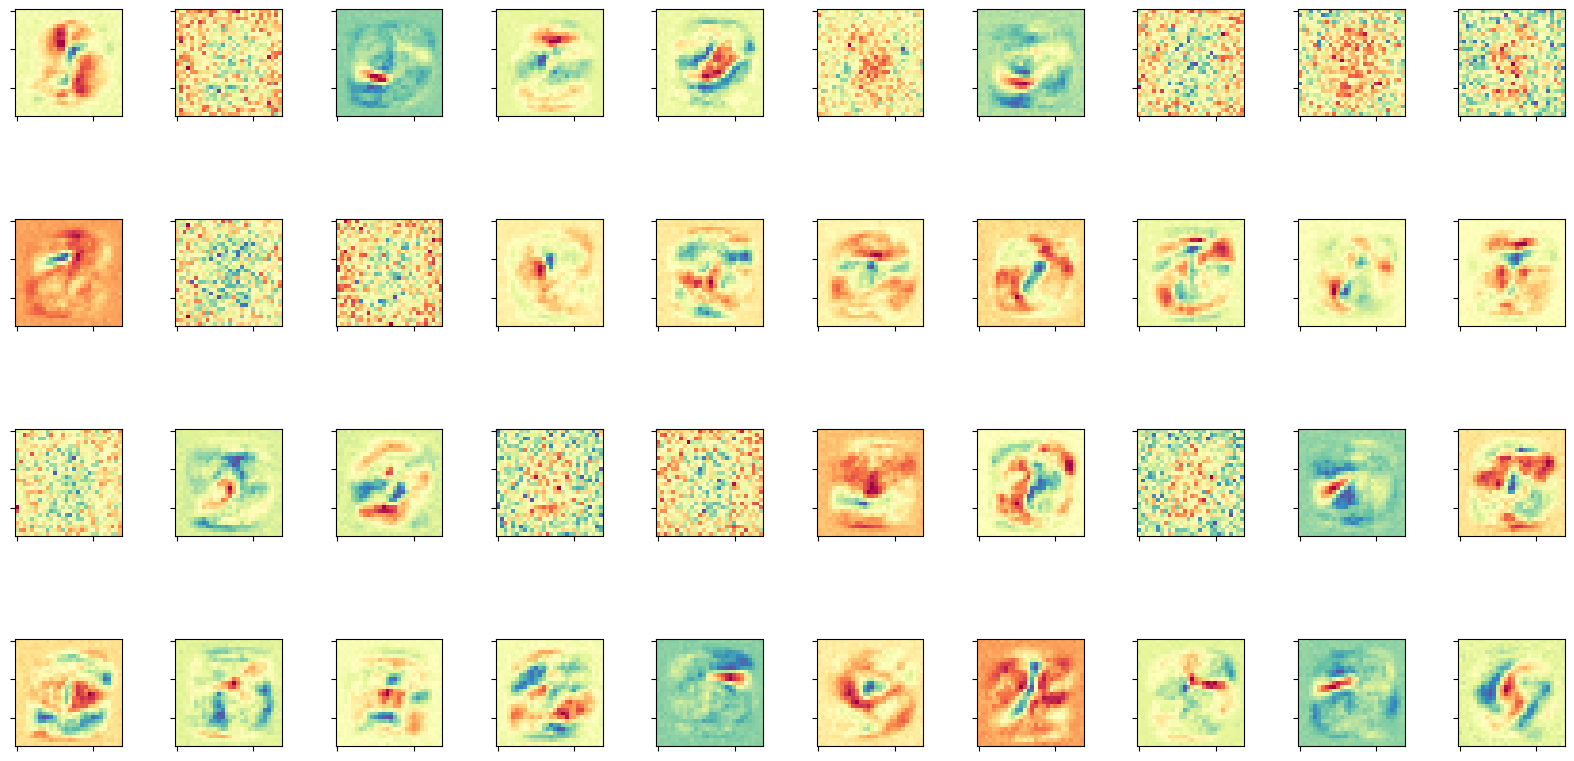

In [9]:
# display weights in first layer
plt.style.use('default') 
displayData(mlp.W[1].T, np.arange(mlp.W[1].shape[0]).reshape(4, 10), labels=False, 
            cmap='Spectral', figsize=(20, 10)) 

# Spiral Data Example

I now consider a highly non-linear classification problem with synthetically generated data.

### Generate/prep data

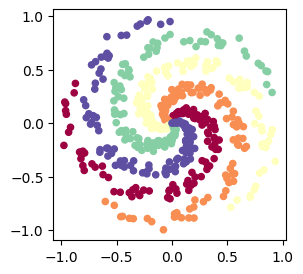

In [10]:
seed = 100 # seed for generating noise
N = 100 # number of points per class
D = 2 # dimensionality
K = 5 # number of classes


X = np.zeros((N * K,D)) # data matrix (each row = single example)
y = np.zeros(N * K, dtype='uint8') # class labels
for j in range(K):
    ix = range(N * j,N * (j + 1))
    r = np.linspace(0.0, 1, N) # radius
    t = np.linspace(j * 5,(j + 1) * 5, N) + np.random.RandomState(seed).randn(N) * 0.2 
    X[ix] = np.c_[r * np.sin(t), r * np.cos(t)]
    y[ix] = j
    
# visualize the data:
plt.style.use('default') 
plt.figure(figsize=(3, 3))
plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap=plt.cm.Spectral);

In [11]:
# prep data
X_pd, Y_ohe = PrepareData(X, y, 5, dtype=np.float32, standardize=False)

# split data into train/validation
X_train, Y_train = X_pd[:, 0:400], Y_ohe[:, 0:400]
X_val, Y_val = X_pd[:, 400:], Y_ohe[:, 400:]

### Training

In [12]:
# instantiate and train model

mlp_spiral = MultiLayerPerceptron([80, 50, 5], 
                                  [relu, relu, softmax], 
                                  reg_loss=l2regloss, 
                                  lmbda=.01,
                                  eta=.01,
                                  n_epochs=200,
                                  weight_seed=1984,
                                  data_seed=2, 
                                  progress_metric=accuracy,
                                  loss=softmax_cross_entropy_loss,
                                  verbose=True)
                            
mlp_spiral.fit(X_train, Y_train, X_val, Y_val);

epoch: 100%|███████████████| 200/200 [00:01<00:00, 181.37epoch/s, loss=0.28/0.36, score=0.96/0.93]                                                


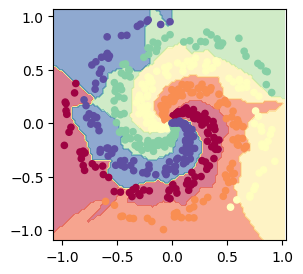

In [13]:
# plot the resulting classifier

h = 0.02
x_min, x_max = X.T[0, :].min() - .1, X.T[0, :].max() + .1
y_min, y_max = X.T[1, :].min() - .1, X.T[1, :].max() + .1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

X_grid = np.c_[xx.ravel(), yy.ravel()]
preds = np.argmax(mlp_spiral.predict(X_grid.T), axis=0)

preds = preds.reshape(xx.shape)

plt.figure(figsize=(3, 3))
plt.contourf(xx, yy, preds, cmap=plt.cm.Spectral, alpha=0.6)
plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap=plt.cm.Spectral)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max);

We see that a neural network can fit highly non-linear relationships.

# Regression Example

As a final example, I consider a regression problem.

### Generate data

In [14]:
# create noisy sine data

f = lambda x: np.sin(x)
low, high = -10, 10

np.random.seed(2021)
X_train = np.random.uniform(low, high, 1000).reshape(1, 1000)
Y_train = f(X_train) + np.random.normal(0, .1, 1000).reshape(1, 1000)

X_val = np.random.uniform(low, high, 100).reshape(1, 100)
Y_val = f(X_val) + np.random.normal(0, .1, 100).reshape(1, 100)

X_train = X_train.astype(np.float32)
Y_train = Y_train.astype(np.float32)
X_val = X_val.astype(np.float32)
Y_val = Y_val.astype(np.float32)

### Training

In [15]:
mlp_sin = MultiLayerPerceptron([100, 100, 1], 
                               [tanh, tanh, identity], 
                               reg_loss=l2regloss, 
                               lmbda=.1,
                               eta=.0005,
                               n_epochs=200,
                               batch_size=100,
                               weight_seed=1984,
                               data_seed=2, 
                               progress_metric=r2,
                               loss=l2loss,
                               verbose=True)

mlp_sin.fit(X_train, Y_train, X_val, Y_val);

epoch: 100%|███████████████| 200/200 [00:03<00:00, 55.24epoch/s, loss=0.04/0.05, score=0.75/0.65]                                                 


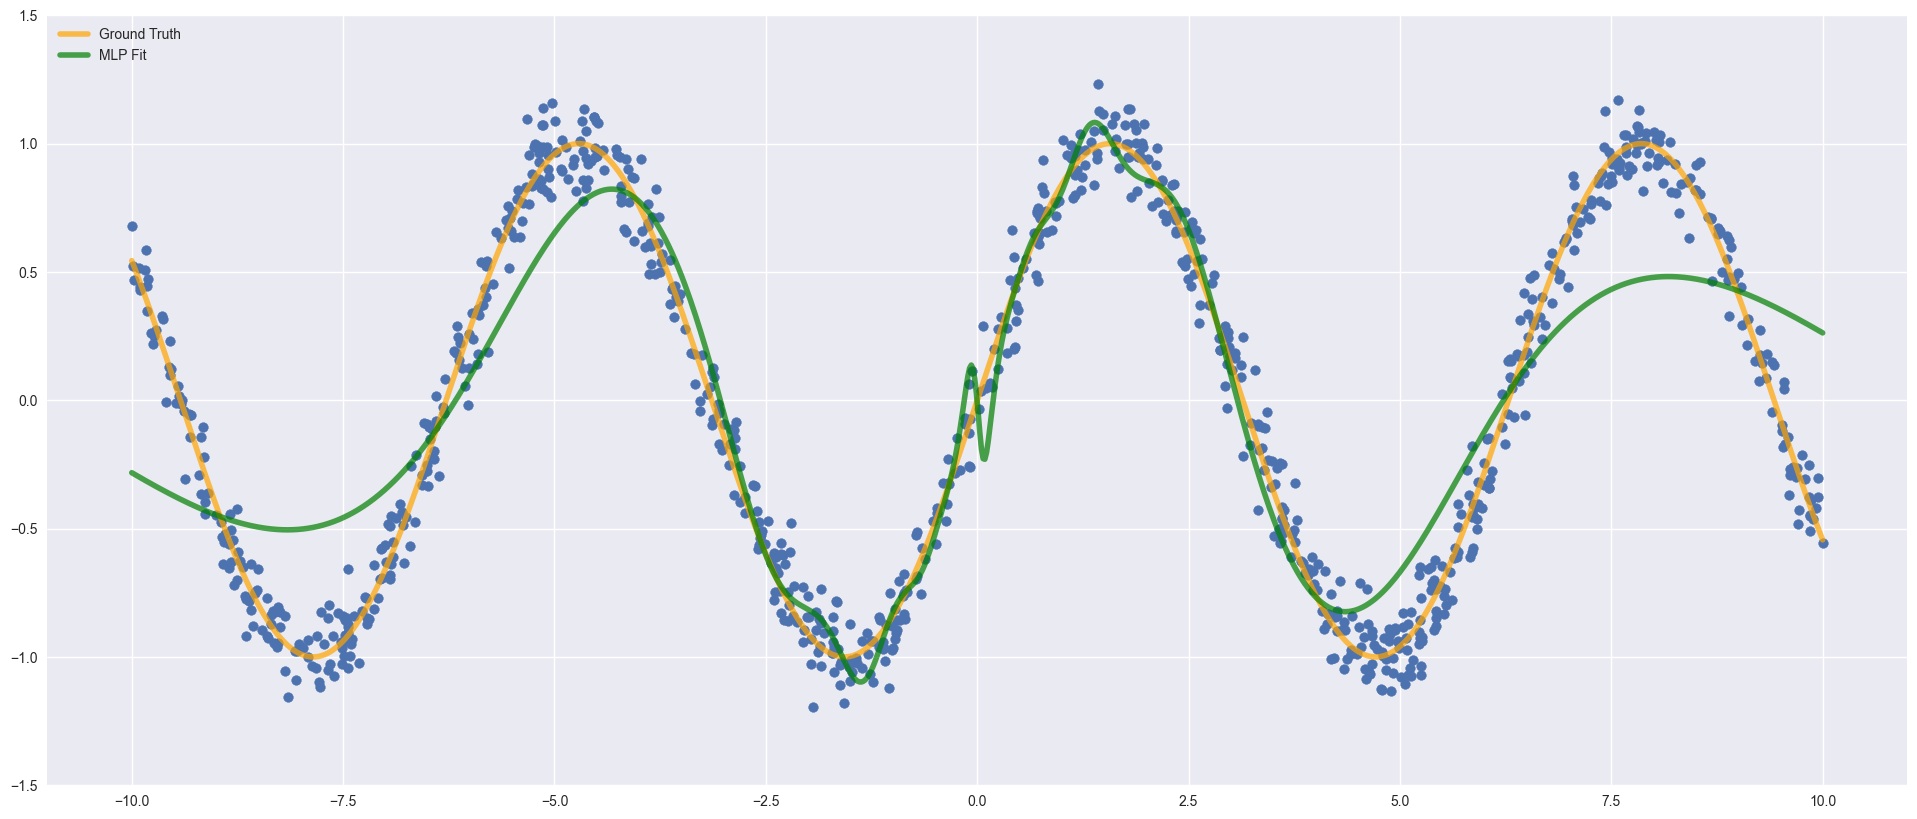

In [16]:
# plot underlying curve, data and MLP fit

plt.style.use('seaborn-v0_8')

x = np.linspace(low, high, 1000).reshape(1, 1000)
y = f(x).reshape(1, 1000)
              
plt.figure(figsize=(24, 10))
plt.scatter(X_train, Y_train)

plt.plot(x.reshape(1000), y.reshape(1000), color='orange', linewidth=4, 
         label='Ground Truth', alpha=.7)
plt.plot(x.reshape(1000), mlp_sin.predict(x).reshape(1000), color='green', 
         linewidth=4, label='MLP Fit', alpha=.7)
plt.legend(loc="upper left");
plt.ylim((-1.5, 1.5));